- Importing Modules
- Importing Data
- Understanding Data
- Building Model
	- train and test splt
	- Scaling the Variables
	- Model
		- statsmodel Linear Regression
		- Sklearn Logistic Regression
		- Generalized regression using Polynomial
		- Ridge Model
		- Lasso Model
		- Generalized Ridge Model
		- Generalized Lasso Model
		- Generalized ElasticNet
- Best Model

## Importing Modules

In [89]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.linear_model import LinearRegression,ElasticNet,Ridge,Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm

## Importing data

In [2]:
train = pd.read_csv('intracity_fare_train.csv',names=['id','timestamp','starting_latitude','starting_longitude',
                                                      'destination_latitude','destination_longitude','vehicle_type',
                                                      'total_luggage_weight','wait_time','traffic_stuck_time',
                                                      'distance','fare'],skiprows=1)
test = pd.read_csv('intracity_fare_test.csv',names=['id','timestamp','starting_latitude','starting_longitude',
                                                      'destination_latitude','destination_longitude','vehicle_type',
                                                      'total_luggage_weight','wait_time','traffic_stuck_time',
                                                      'distance','fare'],skiprows=1)
submission = pd.read_csv('intracity_fare_sample_submission.csv')
train.head()

,id,timestamp,starting_latitude,starting_longitude,destination_latitude,destination_longitude,vehicle_type,total_luggage_weight,wait_time,traffic_stuck_time,distance,fare
0,1,2016-01-21 06:59:49,13.044677,80.235723,13.178228,80.163277,Bus,NaN,NaN,8,34,32.09
1,2,2016-06-17 22:23:30,28.639580,77.074113,28.587288,76.971306,Taxi AC,7.0,9.0,66,34,985.99
2,3,2016-03-16 04:55:18,25.373881,82.969570,25.349656,82.992587,Taxi Non AC,18.0,6.0,53,1,1085.33
3,4,2016-04-26 18:10:09,NaN,NaN,28.758384,77.011422,Metro,NaN,NaN,54,31,56.21
4,5,2016-06-22 01:51:35,22.543506,88.446273,22.706696,88.429522,bus,NaN,NaN,33,44,30.62


## Understanding Data

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
id                       20000 non-null int64
timestamp                20000 non-null object
starting_latitude        19325 non-null float64
starting_longitude       19325 non-null float64
destination_latitude     19337 non-null float64
destination_longitude    19337 non-null float64
vehicle_type             20000 non-null object
total_luggage_weight     5648 non-null float64
wait_time                5648 non-null float64
traffic_stuck_time       20000 non-null int64
distance                 20000 non-null int64
fare                     20000 non-null float64
dtypes: float64(7), int64(3), object(2)
memory usage: 1.8+ MB


In [4]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

In [5]:
# Will extract date,day,month
def extract_date(df):
    df['date'] = df['timestamp'].dt.date
    df['hour'] = df['timestamp'].dt.hour
    df['minute'] = df['timestamp'].dt.minute
    df.drop(columns='timestamp',axis=1,inplace=True)
    return df

In [6]:
train = extract_date(train)
test = extract_date(test)
train.head()

,id,starting_latitude,starting_longitude,destination_latitude,destination_longitude,vehicle_type,total_luggage_weight,wait_time,traffic_stuck_time,distance,fare,date,hour,minute
0,1,13.044677,80.235723,13.178228,80.163277,Bus,NaN,NaN,8,34,32.09,2016-01-21,6,59
1,2,28.639580,77.074113,28.587288,76.971306,Taxi AC,7.0,9.0,66,34,985.99,2016-06-17,22,23
2,3,25.373881,82.969570,25.349656,82.992587,Taxi Non AC,18.0,6.0,53,1,1085.33,2016-03-16,4,55
3,4,NaN,NaN,28.758384,77.011422,Metro,NaN,NaN,54,31,56.21,2016-04-26,18,10
4,5,22.543506,88.446273,22.706696,88.429522,bus,NaN,NaN,33,44,30.62,2016-06-22,1,51


In [7]:
train['vehicle_type'].value_counts()

Bus              1445
bus              1440
taxi ac          1425
Metro            1406
metro            1380
Taxi AC          1373
ac bus            766
AC Bus            765
mini Bus          747
mini bus          739
AC bus            731
auto rickshaw     724
Mini bus          723
Mini Bus          709
Ac Bus            702
Auto rickshaw     699
Auto Rickshaw     692
AUTO RICKSHAW     684
Taxi Non AC       683
taxi non ac       380
taxi Non ac       369
Taxi non Ac       364
taxi Non Ac       361
Taxi non ac       353
taxi non Ac       340
Name: vehicle_type, dtype: int64

In [8]:
def data_correction(df):
    df['vehicle_type'] = [type.capitalize() for type in df['vehicle_type']]
    return df

In [9]:
train = data_correction(train)
test = data_correction(test)
train['vehicle_type'].value_counts()

Ac bus           2964
Mini bus         2918
Bus              2885
Taxi non ac      2850
Auto rickshaw    2799
Taxi ac          2798
Metro            2786
Name: vehicle_type, dtype: int64

In [10]:
des = train.describe(percentiles=[0.2,.3,.4,.5,.7,.9,.95,.96,.97,.99]).T
median = train.select_dtypes(include=['int64','float64']).median()
des['median'] = median
des

,count,mean,std,min,20%,30%,40%,50%,70%,90%,95%,96%,97%,99%,max,median
id,20000.0,10000.500000,5773.647028,1.000000,4000.800000,6000.700000,8000.600000,10000.500000,14000.300000,18000.100000,19000.050000,19200.040000,19400.030000,19800.010000,20000.000000,10000.500000
starting_latitude,19325.0,20.111445,5.908449,12.842900,13.041718,13.131050,19.085958,19.231625,25.270285,28.642194,28.707144,28.719332,28.732843,28.758113,28.770716,19.231625
starting_longitude,19325.0,79.794135,4.939736,72.835882,77.009427,77.174834,77.554304,77.705107,82.968444,88.407017,88.429672,88.433861,88.438337,88.447686,88.452179,77.705107
destination_latitude,19337.0,20.129680,5.909585,12.843029,13.043660,13.132079,19.091360,19.235435,25.273051,28.644534,28.707013,28.720587,28.733205,28.758701,28.770713,19.235435
destination_longitude,19337.0,79.793273,4.941561,72.835873,77.005783,77.168022,77.553455,77.706558,82.968481,88.406768,88.429723,88.434244,88.438771,88.447963,88.452149,77.706558
total_luggage_weight,5648.0,15.447238,8.558223,1.000000,7.000000,9.000000,13.000000,15.000000,21.000000,27.000000,29.000000,29.000000,29.000000,30.000000,30.000000,15.000000
wait_time,5648.0,9.433605,5.779630,0.000000,3.000000,5.000000,7.000000,9.000000,13.000000,17.000000,18.000000,19.000000,19.000000,19.000000,19.000000,9.000000
traffic_stuck_time,20000.0,30.066750,21.951902,0.000000,9.000000,14.000000,20.000000,26.000000,40.000000,63.000000,72.000000,75.000000,78.000000,86.000000,95.000000,26.000000
distance,20000.0,30.543050,12.123407,0.000000,19.000000,24.000000,28.000000,31.000000,38.000000,45.000000,47.000000,47.000000,48.000000,48.000000,99.000000,31.000000
fare,20000.0,251.926063,300.067490,7.000000,38.280000,46.670000,58.576000,75.330000,348.181000,690.551000,882.020000,943.015600,1014.574500,1222.000000,1972.000000,75.330000


In [11]:
print(100 * train.isnull().sum() / train.shape[0])

def drop_null_columns(df,col):
    df.drop(columns=col,axis=1,inplace=True)
    return df

train = drop_null_columns(train,['total_luggage_weight','wait_time'])
test = drop_null_columns(test,['total_luggage_weight','wait_time'])

print(100 * train.isnull().sum() / train.shape[0])

id                        0.000
starting_latitude         3.375
starting_longitude        3.375
destination_latitude      3.315
destination_longitude     3.315
vehicle_type              0.000
total_luggage_weight     71.760
wait_time                71.760
traffic_stuck_time        0.000
distance                  0.000
fare                      0.000
date                      0.000
hour                      0.000
minute                    0.000
dtype: float64
id                       0.000
starting_latitude        3.375
starting_longitude       3.375
destination_latitude     3.315
destination_longitude    3.315
vehicle_type             0.000
traffic_stuck_time       0.000
distance                 0.000
fare                     0.000
date                     0.000
hour                     0.000
minute                   0.000
dtype: float64


In [12]:
mean = train.loc[:,train.isnull().sum() != 0].mean()
median = train.loc[:,train.isnull().sum() != 0].median()
df = pd.DataFrame({'Mean':mean,'Median':median})
df

,Mean,Median
starting_latitude,20.111445,19.231625
starting_longitude,79.794135,77.705107
destination_latitude,20.129680,19.235435
destination_longitude,79.793273,77.706558


In [13]:
def fill_null_mean(df,columns):
    for column in columns:
        df[column].fillna(df[column].mean(),inplace=True)
    return df

In [14]:
columns = train.loc[:,train.isnull().sum() != 0].columns

train = fill_null_mean(train,columns)
test = fill_null_mean(test,columns)

train.describe()

,id,starting_latitude,starting_longitude,destination_latitude,destination_longitude,traffic_stuck_time,distance,fare,hour,minute
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,10000.500000,20.111445,79.794135,20.129680,79.793273,30.066750,30.543050,251.926063,11.465350,29.555450
std,5773.647028,5.807884,4.855658,5.810803,4.858960,21.951902,12.123407,300.067490,6.893415,17.296846
min,1.000000,12.842900,72.835882,12.843029,72.835873,0.000000,0.000000,7.000000,0.000000,0.000000
25%,5000.750000,13.094489,77.105839,13.095927,77.100530,12.000000,22.000000,42.097500,5.000000,15.000000
50%,10000.500000,20.111445,79.794135,20.129680,79.793273,26.000000,31.000000,75.330000,11.000000,30.000000
75%,15000.250000,25.309045,82.986794,25.310355,82.985936,45.000000,40.000000,416.130000,17.000000,45.000000
max,20000.000000,28.770716,88.452179,28.770713,88.452149,95.000000,99.000000,1972.000000,23.000000,59.000000


In [15]:
print(train.info())
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
id                       20000 non-null int64
starting_latitude        20000 non-null float64
starting_longitude       20000 non-null float64
destination_latitude     20000 non-null float64
destination_longitude    20000 non-null float64
vehicle_type             20000 non-null object
traffic_stuck_time       20000 non-null int64
distance                 20000 non-null int64
fare                     20000 non-null float64
date                     20000 non-null object
hour                     20000 non-null int64
minute                   20000 non-null int64
dtypes: float64(5), int64(5), object(2)
memory usage: 1.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
id                       20000 non-null int64
starting_latitude        20000 non-null float64
starting_longitude       20000 non-null float64
destinati

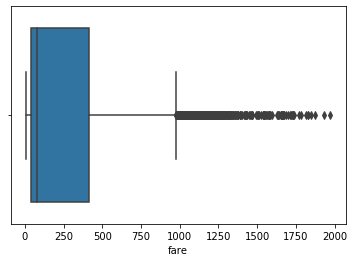

In [16]:
sns.boxplot('fare',data=train)

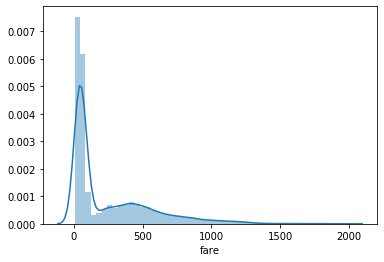

In [17]:
sns.distplot(train['fare'])

In [18]:
train.head()

,id,starting_latitude,starting_longitude,destination_latitude,destination_longitude,vehicle_type,traffic_stuck_time,distance,fare,date,hour,minute
0,1,13.044677,80.235723,13.178228,80.163277,Bus,8,34,32.09,2016-01-21,6,59
1,2,28.639580,77.074113,28.587288,76.971306,Taxi ac,66,34,985.99,2016-06-17,22,23
2,3,25.373881,82.969570,25.349656,82.992587,Taxi non ac,53,1,1085.33,2016-03-16,4,55
3,4,20.111445,79.794135,28.758384,77.011422,Metro,54,31,56.21,2016-04-26,18,10
4,5,22.543506,88.446273,22.706696,88.429522,Bus,33,44,30.62,2016-06-22,1,51


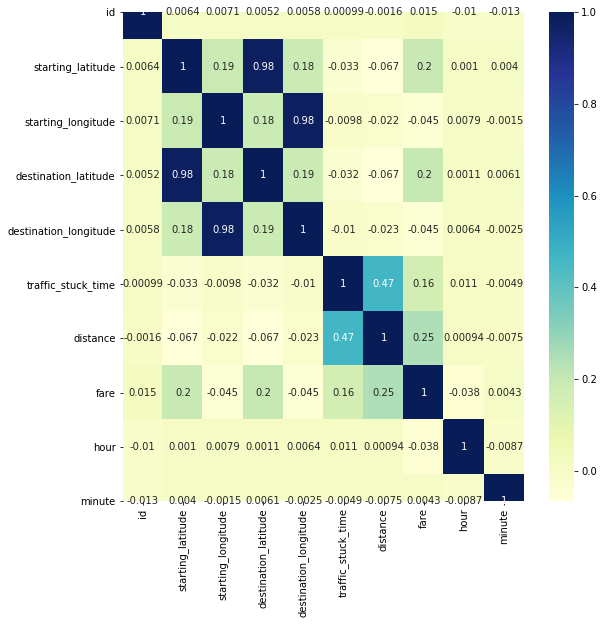

In [19]:
corr = train.corr()
plt.figure(figsize=[9,9])
sns.heatmap(corr,cmap='YlGnBu',annot=True)
plt.show()

In [20]:
def drop_destination(df):
    df.drop(columns=['destination_latitude','destination_longitude'],axis=1,inplace=True)
    return df

train = drop_destination(train)
test = drop_destination(test)

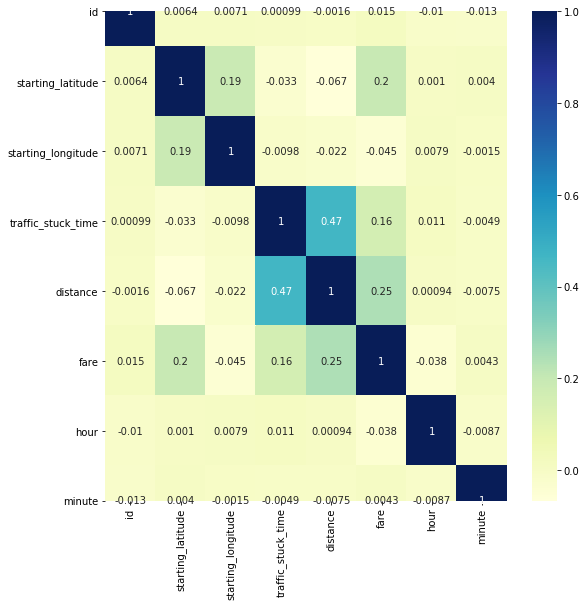

In [21]:
corr = train.corr()
plt.figure(figsize=[9,9])
sns.heatmap(corr,cmap='YlGnBu',annot=True)
plt.show()

In [22]:
train.head()

,id,starting_latitude,starting_longitude,vehicle_type,traffic_stuck_time,distance,fare,date,hour,minute
0,1,13.044677,80.235723,Bus,8,34,32.09,2016-01-21,6,59
1,2,28.639580,77.074113,Taxi ac,66,34,985.99,2016-06-17,22,23
2,3,25.373881,82.969570,Taxi non ac,53,1,1085.33,2016-03-16,4,55
3,4,20.111445,79.794135,Metro,54,31,56.21,2016-04-26,18,10
4,5,22.543506,88.446273,Bus,33,44,30.62,2016-06-22,1,51


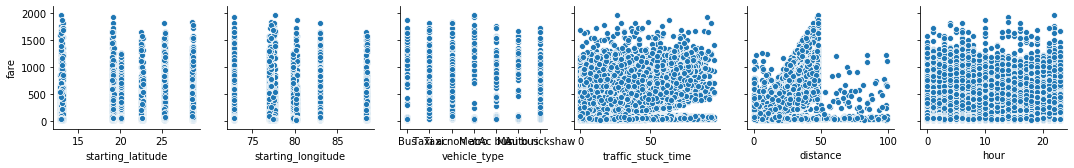

In [23]:
sns.pairplot(data=train,
            x_vars=['starting_latitude','starting_longitude','vehicle_type','traffic_stuck_time','distance','hour'],
            y_vars='fare')

In [24]:
pd.to_datetime(train['date']).dt.year.unique()

array([2016, 2015], dtype=int64)

In [25]:
ID = test['id']

def drop_id(df):
    df.drop(columns='id',inplace=True,axis=1)
    return df

train = drop_id(train)
test = drop_id(test)

train.head()

,starting_latitude,starting_longitude,vehicle_type,traffic_stuck_time,distance,fare,date,hour,minute
0,13.044677,80.235723,Bus,8,34,32.09,2016-01-21,6,59
1,28.639580,77.074113,Taxi ac,66,34,985.99,2016-06-17,22,23
2,25.373881,82.969570,Taxi non ac,53,1,1085.33,2016-03-16,4,55
3,20.111445,79.794135,Metro,54,31,56.21,2016-04-26,18,10
4,22.543506,88.446273,Bus,33,44,30.62,2016-06-22,1,51


In [26]:
train['vehicle_type'].value_counts()

dict = {'Ac bus':1,'Mini bus':2,'Bus':3,'Taxi non ac':4,'Auto rickshaw':5,'Taxi ac':6,'Metro':7}

train['vehicle_type'] = train['vehicle_type'].replace(dict)
test['vehicle_type'] = test['vehicle_type'].replace(dict)

train['vehicle_type'].value_counts()

1    2964
2    2918
3    2885
4    2850
5    2799
6    2798
7    2786
Name: vehicle_type, dtype: int64

In [27]:
test.head()

,starting_latitude,starting_longitude,vehicle_type,traffic_stuck_time,distance,fare,date,hour,minute
0,28.666631,77.092389,7,10,17,NaN,2016-07-19,6,56
1,12.863124,77.465198,7,28,27,NaN,2016-01-10,16,56
2,19.203644,72.861170,1,34,45,NaN,2015-07-14,9,49
3,28.668365,77.030327,7,17,14,NaN,2015-03-24,10,6
4,13.050678,80.212654,2,9,10,NaN,2016-04-05,23,3


In [28]:
train['year'] = pd.to_datetime(train['date']).dt.year
train['month'] = pd.to_datetime(train['date']).dt.month
train['day'] = pd.to_datetime(train['date']).dt.day
train.drop('date',axis=1,inplace=True)

test['year'] = pd.to_datetime(test['date']).dt.year
test['month'] = pd.to_datetime(test['date']).dt.month
test['day'] = pd.to_datetime(test['date']).dt.day
test.drop('date',axis=1,inplace=True)

train.head()

,starting_latitude,starting_longitude,vehicle_type,traffic_stuck_time,distance,fare,hour,minute,year,month,day
0,13.044677,80.235723,3,8,34,32.09,6,59,2016,1,21
1,28.639580,77.074113,6,66,34,985.99,22,23,2016,6,17
2,25.373881,82.969570,4,53,1,1085.33,4,55,2016,3,16
3,20.111445,79.794135,7,54,31,56.21,18,10,2016,4,26
4,22.543506,88.446273,3,33,44,30.62,1,51,2016,6,22


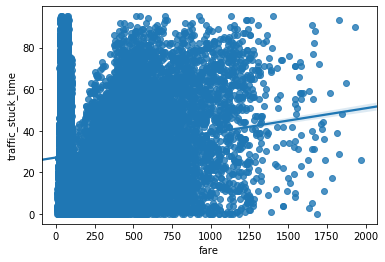

In [29]:
sns.regplot(x='fare',y='traffic_stuck_time',data=train)

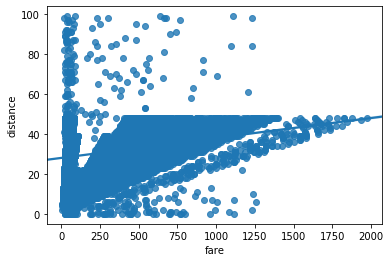

In [30]:
sns.regplot(x='fare',y='distance',data=train)

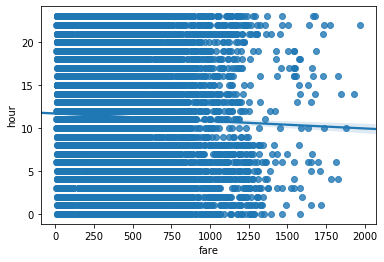

In [31]:
sns.regplot(x='fare',y='hour',data=train)

## Model Building

### train and test splt

In [32]:
X = train.drop(['fare'],axis=1)
y = train['fare']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [33]:
X_train.head()

,starting_latitude,starting_longitude,vehicle_type,traffic_stuck_time,distance,hour,minute,year,month,day
7070,19.058050,72.882989,3,47,27,16,14,2015,8,7
13010,12.966287,77.575593,6,68,37,13,50,2016,9,26
6688,25.260171,82.985504,4,3,9,12,26,2016,9,8
9976,13.108723,80.252728,4,15,8,17,46,2016,10,6
5175,13.047533,77.471553,3,25,21,21,26,2015,4,23


In [34]:
X_test.head()

,starting_latitude,starting_longitude,vehicle_type,traffic_stuck_time,distance,hour,minute,year,month,day
10650,22.455887,88.381044,6,3,35,0,38,2015,9,17
2041,22.559408,88.409681,7,16,14,23,9,2016,2,1
8668,12.902701,80.201813,4,33,47,19,13,2015,9,10
1114,20.111445,79.794135,5,86,48,11,34,2016,12,16
13902,12.990956,80.219961,3,60,35,16,48,2016,3,3


In [112]:
columns = X_train.columns
columns

Index(['starting_latitude', 'starting_longitude', 'vehicle_type',
       'traffic_stuck_time', 'distance', 'hour', 'minute', 'year', 'month',
       'day'],
      dtype='object')

### Scaling the Variables

In [36]:
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns=columns)

X_train.describe()

,starting_latitude,starting_longitude,vehicle_type,traffic_stuck_time,distance,hour,minute,year,month,day
count,1.340000e+04,1.340000e+04,1.340000e+04,1.340000e+04,1.340000e+04,1.340000e+04,1.340000e+04,1.340000e+04,1.340000e+04,1.340000e+04
mean,-1.059807e-16,1.238727e-15,-5.054000e-18,6.080128e-17,2.101718e-16,-5.115311e-16,-3.378724e-17,2.022181e-13,-1.384630e-16,-1.669519e-16
std,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00
min,-1.249071e+00,-1.426227e+00,-1.477496e+00,-1.369359e+00,-2.524205e+00,-1.662874e+00,-1.712458e+00,-9.870981e-01,-1.596841e+00,-1.676511e+00
25%,-1.205743e+00,-5.502779e-01,-9.784549e-01,-8.229612e-01,-7.066201e-01,-7.936181e-01,-8.479189e-01,-9.870981e-01,-7.307371e-01,-8.062082e-01
50%,-1.422894e-01,2.426418e-03,1.962645e-02,-1.854967e-01,3.693742e-02,7.563828e-02,1.661979e-02,-9.870981e-01,1.353664e-01,-6.023459e-02
75%,9.031880e-01,6.579259e-01,1.017708e+00,6.796337e-01,7.804949e-01,8.000186e-01,8.811585e-01,1.013070e+00,1.001470e+00,8.100680e-01
max,1.501521e+00,1.780085e+00,1.516748e+00,2.956293e+00,5.654928e+00,1.669275e+00,1.688061e+00,1.013070e+00,1.578872e+00,1.680371e+00


In [37]:
X_test.describe()

,starting_latitude,starting_longitude,vehicle_type,traffic_stuck_time,distance,hour,minute,year,month,day
count,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000
mean,0.018613,0.007353,-0.005552,-0.000984,-0.002469,-0.005514,-0.027280,0.020866,-0.027531,0.011612
std,1.008858,0.990733,0.999181,0.998605,1.004856,0.996017,0.990383,1.000129,0.987653,0.997916
min,-1.249065,-1.426233,-1.477496,-1.369359,-2.524205,-1.662874,-1.712458,-0.987098,-1.596841,-1.676511
25%,-1.205449,-0.547807,-0.978455,-0.822961,-0.706620,-0.938494,-0.905555,-0.987098,-1.019438,-0.806208
50%,0.006142,0.002426,0.019626,-0.185497,0.036937,-0.069238,-0.041016,1.013070,-0.153335,0.064094
75%,0.904966,0.657978,1.017708,0.679634,0.780495,0.800019,0.823523,1.013070,0.712769,0.810068
max,1.501499,1.780078,1.516748,2.956293,5.654928,1.669275,1.688061,1.013070,1.578872,1.680371


### Model

#### statsmodel Linear Regression

##### Adding contanst

In [38]:
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

C:\Users\dhiraj.a.mishra\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


#### Building model

In [39]:
X_train_sm.head()

,const,starting_latitude,starting_longitude,vehicle_type,traffic_stuck_time,distance,hour,minute,year,month,day
0,1.0,-0.175770,-1.416561,-0.479414,0.770700,-0.293533,0.655143,-0.905555,-0.987098,0.424068,-0.930537
1,1.0,-1.227763,-0.453082,1.017708,1.726897,0.532642,0.220514,1.169338,1.013070,0.712769,1.431713
2,1.0,0.895281,0.657674,0.019626,-1.232760,-1.780648,0.075638,-0.213924,1.013070,0.712769,-0.806208
3,1.0,-1.203165,0.096584,0.019626,-0.686362,-1.863265,0.800019,0.938794,1.013070,1.001470,-1.054866
4,1.0,-1.213732,-0.474443,-0.479414,-0.231030,-0.789238,1.379523,-0.213924,-0.987098,-0.730737,1.058726


In [40]:
model = sm.OLS(y_train.values,X_train_sm).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     367.9
Date:                Wed, 25 Mar 2020   Prob (F-statistic):               0.00
Time:                        18:00:24   Log-Likelihood:                -93707.
No. Observations:               13400   AIC:                         1.874e+05
Df Residuals:                   13389   BIC:                         1.875e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                250.2263      2.277    109.871      0.000     245.762     254.690
starting_latitude     69.1835      2.328     29.715      0.000      64.620      73.747
starting_longitude   -20.8779      2.321     -8.995      0.000     -25.428     -16.328
vehicle_type          97.2889      2.281     42.653      0.000      92.818     101.760
traffic_stuck_time    19.1872      2.574      7.454      0.000      14.142      24.233
distance              65.3731      2.579     25.349      0.000      60.318      70.428
hour                 -10.6477      2.278     -4.674      0.000     -15.113      -6.183
minute                 1.6384      2.278      0.719      0.472      -2.826       6.103
year                  -1.0187      2.278     -0.447      0.655      -5.484       3.447
month                  2.6654      2.278      1.170      0.242      -1.800       7.131
day                   -1.7586      2.278     -0.772      0.440      -6.224       2.707
==============================================================================
Omnibus:                     2318.276   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5864.480
Skew:                           0.960   Prob(JB):                         0.00
Kurtosis:                       5.612   Cond. No.                         1.67
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
model = sm.OLS(y_train.values,X_train_sm.drop(['year','minute','day','month'],axis=1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     612.8
Date:                Wed, 25 Mar 2020   Prob (F-statistic):               0.00
Time:                        18:00:24   Log-Likelihood:                -93709.
No. Observations:               13400   AIC:                         1.874e+05
Df Residuals:                   13393   BIC:                         1.875e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                250.2263      2.277    109.877      0.000     245.762     254.690
starting_latitude     69.1750      2.327     29.722      0.000      64.613      73.737
starting_longitude   -20.8680      2.321     -8.991      0.000     -25.417     -16.319
vehicle_type          97.2907      2.281     42.658      0.000      92.820     101.761
traffic_stuck_time    19.1783      2.574      7.451      0.000      14.133      24.223
distance              65.3467      2.578     25.344      0.000      60.293      70.401
hour                 -10.6414      2.278     -4.672      0.000     -15.106      -6.177
==============================================================================
Omnibus:                     2317.973   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5863.204
Skew:                           0.959   Prob(JB):                         0.00
Kurtosis:                       5.611   Cond. No.                         1.67
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Logistic Regression

In [42]:
log = LinearRegression()
log.fit(X_train.drop(['year','minute','day','month'],axis=1),y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

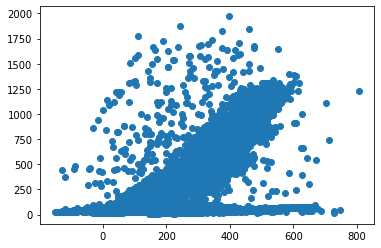

In [43]:
train_pred = log.predict(X_train.drop(['year','minute','day','month'],axis=1))
plt.scatter(train_pred,y_train)

### Generalized regression using Polynomial

In [54]:
R2_Test=[]
R2_Train=[]
degrees = [1,2,3,4,5,6,7]

for degree in degrees:
    model = Pipeline([('Poly_Mode',PolynomialFeatures(degree=degree)),('Log_model',LinearRegression())])
    model = model.fit(X_train.drop(['year','minute','day','month'],axis=1),y_train.values.reshape(-1,1))
    test_score = model.score(X_test.drop(['year','minute','day','month'],axis=1),y_test)
    train_score = model.score(X_train.drop(['year','minute','day','month'],axis=1),y_train)
    R2_Test.append(test_score)
    R2_Train.append(train_score)
    
# respective test r-squared scores of predictions
df = pd.DataFrame({'Degree':degrees,'R2_Train':R2_Train,'R2_Test':R2_Test})
df

,Degree,R2_Train,R2_Test
0,1,0.215389,0.250764
1,2,0.416358,0.446305
2,3,0.679865,0.704453
3,4,0.744809,0.759962
4,5,0.759625,0.753586
5,6,0.835502,0.779385
6,7,0.857658,-1.476744


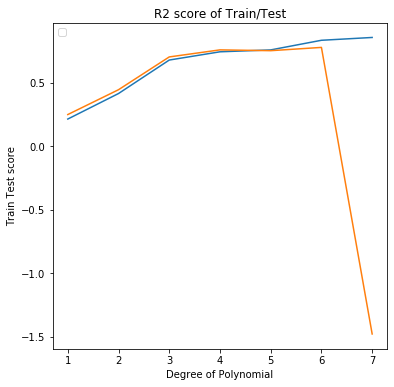

In [60]:
plt.figure(figsize=[6,6])
plt.xlabel('Degree of Polynomial')
plt.ylabel('Train Test score')
plt.title('R2 score of Train/Test')
plt.legend(['Train score','Test score'],loc='upper left')
plt.plot(df['Degree'],df['R2_Train'])
plt.plot(df['Degree'],df['R2_Test'])
plt.show()

### Ridge Model

In [51]:
folds = KFold(n_splits=5,shuffle=True)
parameters = {'alpha':[0.0001,0.001,0.01,0.05,0.7,0.8,1,2,3,4,5,6,7,8,9,10,20,30,40,50,100,200,300,400,500]}
model = Ridge()
GC_model = GridSearchCV(estimator=model,param_grid=parameters,cv=folds,return_train_score=True,scoring='r2',verbose=1)
GC_model.fit(X_train.drop(['year','minute','day','month'],axis=1),y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.8s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.7, 0.8, 1, 2, 3,
                                   4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 100,
                                   200, 300, 400, 500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1)

In [66]:
score = pd.DataFrame(GC_model.cv_results_)
score.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.034986,0.062451,0.000000,0.000000,0.0001,{'alpha': 0.0001},0.239095,0.189432,0.196061,0.238345,...,0.212754,0.02151,20,0.208295,0.221323,0.219335,0.209297,0.218918,0.215434,0.005489
1,0.001596,0.002054,0.000599,0.000799,0.001,{'alpha': 0.001},0.239095,0.189432,0.196061,0.238345,...,0.212754,0.02151,19,0.208295,0.221323,0.219335,0.209297,0.218918,0.215434,0.005489
2,0.004386,0.001490,0.001395,0.000488,0.01,{'alpha': 0.01},0.239095,0.189432,0.196061,0.238345,...,0.212754,0.02151,18,0.208295,0.221323,0.219335,0.209297,0.218918,0.215434,0.005489


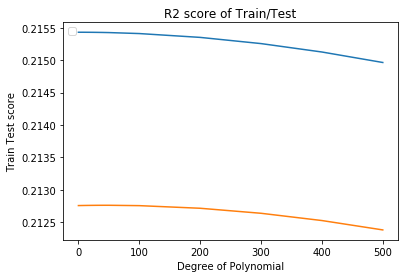

In [69]:
# plt.figure(figsize=[6,6])
plt.xlabel('Degree of Polynomial')
plt.ylabel('Train Test score')
plt.title('R2 score of Train/Test')
plt.legend(['Train score','Test score'],loc='upper left')
plt.plot(score['param_alpha'],score['mean_train_score'])
plt.plot(score['param_alpha'],score['mean_test_score'])
plt.show()

### Lasso Model

In [70]:
folds = KFold(n_splits=5,shuffle=True)
parameters = {'alpha':[0.0001,0.001,0.01,0.05,0.7,0.8,1,2,3,4,5,6,7,8,9,10,20,30,40,50,100,200,300,400,500]}
model = Lasso()
GC_model = GridSearchCV(estimator=model,param_grid=parameters,cv=folds,return_train_score=True,scoring='r2',verbose=1)
GC_model.fit(X_train.drop(['year','minute','day','month'],axis=1),y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.7s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.7, 0.8, 1, 2, 3,
                                   4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 100,
                                   200, 300, 400, 500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1)

In [71]:
score = pd.DataFrame(GC_model.cv_results_)
score.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.006781,0.000745,0.001796,0.000399,0.0001,{'alpha': 0.0001},0.224277,0.221827,0.196667,0.202439,...,0.213831,0.011830,4,0.212711,0.21368,0.219659,0.218356,0.213142,0.21551,0.002902
1,0.004389,0.001017,0.001600,0.000493,0.001,{'alpha': 0.001},0.224277,0.221826,0.196667,0.202440,...,0.213831,0.011830,3,0.212711,0.21368,0.219659,0.218356,0.213142,0.21551,0.002902
2,0.003934,0.006051,0.000000,0.000000,0.01,{'alpha': 0.01},0.224274,0.221823,0.196668,0.202446,...,0.213831,0.011828,2,0.212711,0.21368,0.219659,0.218356,0.213142,0.21551,0.002902


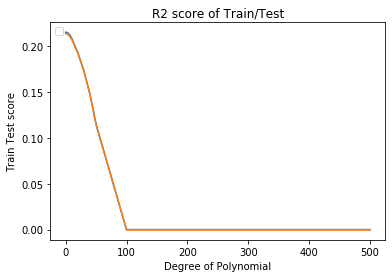

In [72]:
# plt.figure(figsize=[6,6])
plt.xlabel('Degree of Polynomial')
plt.ylabel('Train Test score')
plt.title('R2 score of Train/Test')
plt.legend(['Train score','Test score'],loc='upper left')
plt.plot(score['param_alpha'],score['mean_train_score'])
plt.plot(score['param_alpha'],score['mean_test_score'])
plt.show()

### Generalized Ridge Model

In [78]:
R2_Test=[]
R2_Train=[]
degrees = [1,2,3,4,5,6,7]

for degree in degrees:
    model = Pipeline([('Poly_Mode',PolynomialFeatures(degree=degree)),('Ridge',Ridge())])
    model = model.fit(X_train.drop(['year','minute','day','month'],axis=1),y_train.values.reshape(-1,1))
    test_score = model.score(X_test.drop(['year','minute','day','month'],axis=1),y_test)
    train_score = model.score(X_train.drop(['year','minute','day','month'],axis=1),y_train)
    R2_Test.append(test_score)
    R2_Train.append(train_score)
    
# respective test r-squared scores of predictions
df = pd.DataFrame({'Degree':degrees,'R2_Train':R2_Train,'R2_Test':R2_Test})
df

Building model for  1
Building model for  2
Building model for  3
Building model for  4
Building model for  5
Building model for  6
Building model for  7


,Degree,R2_Train,R2_Test
0,1,0.215389,0.250760
1,2,0.416357,0.446302
2,3,0.679855,0.704490
3,4,0.744678,0.760206
4,5,0.759399,0.754883
5,6,0.834087,0.793538
6,7,0.853961,-0.023335


### Generalized Lasso Model

In [82]:
R2_Test=[]
R2_Train=[]
degrees = [1,2,3,4,5,6,7,8,9]

for degree in degrees:
    model = Pipeline([('Poly_Mode',PolynomialFeatures(degree=degree)),('Lasso',Lasso())])
    model = model.fit(X_train.drop(['year','minute','day','month'],axis=1),y_train.values.reshape(-1,1))
    test_score = model.score(X_test.drop(['year','minute','day','month'],axis=1),y_test)
    train_score = model.score(X_train.drop(['year','minute','day','month'],axis=1),y_train)
    R2_Test.append(test_score)
    R2_Train.append(train_score)
    
# respective test r-squared scores of predictions
df = pd.DataFrame({'Degree':degrees,'R2_Train':R2_Train,'R2_Test':R2_Test})
df

C:\Users\dhiraj.a.mishra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 150680896.68037277, tolerance: 118626.88529940759
  positive)
C:\Users\dhiraj.a.mishra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 149046018.42384845, tolerance: 118626.88529940759
  positive)
C:\Users\dhiraj.a.mishra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151115830.77979803, tolerance: 118626.88529940759
  positive)
C:\Users\dhiraj.a.mishra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model

,Degree,R2_Train,R2_Test
0,1,0.215322,0.249967
1,2,0.415777,0.445015
2,3,0.676298,0.700400
3,4,0.739224,0.757258
4,5,0.748998,0.756779
5,6,0.769584,0.766883
6,7,0.772527,0.724243
7,8,0.793441,0.571453
8,9,0.800817,0.187321


In [98]:
parameters = {'alpha':[0.0001,0.001,0.01,0.05,0.7,0.8,1,2,3,4,5,6,7,8,9,10,20,30,40,50,100,200,300,400,500]}
model = ElasticNet(normalize=True,precompute=True)
kfold = KFold(n_splits=5,shuffle=True)
Gc_Model = GridSearchCV(estimator=model,param_grid=parameters,verbose=1,cv=folds,return_train_score=True)
Gc_Model.fit(X_train.drop(['year','minute','day','month'],axis=1),y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    1.1s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=True,
                                  positive=False, precompute=True,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.7, 0.8, 1, 2, 3,
                                   4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 100,
                                   200, 300, 400, 500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=1)

In [99]:
scores = pd.DataFrame(Gc_Model.cv_results_)
scores.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.031396,0.047683,0.000000,0.000000,0.0001,{'alpha': 0.0001},0.190974,0.188804,0.180536,0.194049,...,0.188088,0.004592,1,0.187939,0.188633,0.191769,0.185918,0.188930,0.188638,0.001885
1,0.006250,0.007654,0.000000,0.000000,0.001,{'alpha': 0.001},0.064792,0.063987,0.062201,0.064524,...,0.063607,0.001051,2,0.063161,0.063889,0.064878,0.062642,0.064279,0.063770,0.000793
2,0.006546,0.007300,0.001595,0.001017,0.01,{'alpha': 0.01},0.008211,0.008104,0.007822,0.008131,...,0.008039,0.000143,3,0.007989,0.008106,0.008231,0.007930,0.008171,0.008085,0.000112


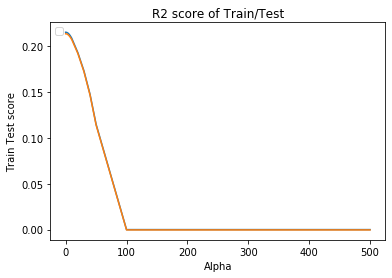

In [100]:
# plt.figure(figsize=[6,6])
plt.xlabel('Alpha')
plt.ylabel('Train Test score')
plt.title('R2 score of Train/Test')
plt.legend(['Train score','Test score'],loc='upper left')
plt.plot(score['param_alpha'],score['mean_train_score'])
plt.plot(score['param_alpha'],score['mean_test_score'])
plt.show()

### Generalized ElasticNet

In [105]:
R2_Test=[]
R2_Train=[]
degrees = [1,2,3,4,5,6,7]

for degree in degrees:
    model = Pipeline([('Poly_Mode',PolynomialFeatures(degree=degree)),('ElasticNet',ElasticNet(normalize=True,precompute=True))])
    model = model.fit(X_train.drop(['year','minute','day','month'],axis=1),y_train)
    test_score = model.score(X_test.drop(['year','minute','day','month'],axis=1),y_test)
    train_score = model.score(X_train.drop(['year','minute','day','month'],axis=1),y_train)
    R2_Test.append(test_score)
    R2_Train.append(train_score)
    
# respective test r-squared scores of predictions
df = pd.DataFrame({'Degree':degrees,'R2_Train':R2_Train,'R2_Test':R2_Test})
df

,Degree,R2_Train,R2_Test
0,1,0.000015,-0.000269
1,2,0.000036,-0.000250
2,3,0.000048,-0.000237
3,4,0.000074,-0.000212
4,5,0.000085,-0.000200
5,6,0.000121,-0.000165
6,7,0.000127,-0.000159


## Best Model

In [120]:
model = Pipeline([('Poly_Mode',PolynomialFeatures(degree=6)),('Lasso',Lasso())])
model = model.fit(X_train.drop(['year','minute','day','month'],axis=1),y_train)
model

C:\Users\dhiraj.a.mishra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 150680896.68037277, tolerance: 118626.88529940759
  positive)


Pipeline(memory=None,
         steps=[('Poly_Mode',
                 PolynomialFeatures(degree=6, include_bias=True,
                                    interaction_only=False, order='C')),
                ('Lasso',
                 Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=None, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

In [113]:
train.head()

,starting_latitude,starting_longitude,vehicle_type,traffic_stuck_time,distance,fare,hour,minute,year,month,day
0,13.044677,80.235723,3,8,34,32.09,6,59,2016,1,21
1,28.639580,77.074113,6,66,34,985.99,22,23,2016,6,17
2,25.373881,82.969570,4,53,1,1085.33,4,55,2016,3,16
3,20.111445,79.794135,7,54,31,56.21,18,10,2016,4,26
4,22.543506,88.446273,3,33,44,30.62,1,51,2016,6,22


In [116]:
col = ['starting_latitude', 'starting_longitude', 'vehicle_type','traffic_stuck_time', 'distance', 'hour', 'minute', 'year', 'month','day']
test[col] = scaler.transform(test[col])

In [124]:
pred_fare = model.predict(test.drop(['year','minute','day','month','fare'],axis=1))
train['fare'] = pred_fare
train.head()

,starting_latitude,starting_longitude,vehicle_type,traffic_stuck_time,distance,fare,hour,minute,year,month,day
0,13.044677,80.235723,3,8,34,32.940732,6,59,2016,1,21
1,28.639580,77.074113,6,66,34,14.842741,22,23,2016,6,17
2,25.373881,82.969570,4,53,1,106.725310,4,55,2016,3,16
3,20.111445,79.794135,7,54,31,23.671024,18,10,2016,4,26
4,22.543506,88.446273,3,33,44,70.904755,1,51,2016,6,22


In [130]:
submission =  pd.DataFrame({'ID':ID,'FARE':pred_fare})
submission.to_csv('submission.csv',index=False)